In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import dlib
import pickle
import h5py
import cv2
import scipy

In [0]:
%tensorflow_version 2.x
import tensorflow as tf

In [0]:
dataset = pd.read_csv('/content/drive/My Drive/Datasets/fer2013.csv')

In [0]:
def get_images(usage):
  df = dataset[dataset['Usage'] == usage]
  y = tf.keras.utils.to_categorical(df['emotion'])
  X = np.array([values.split() for values in df['pixels']])
  X = X.astype(np.float).reshape(len(df), 48, 48, 1)
  return (X, y)

In [0]:
X_train, y_train = get_images('Training')
X_test, y_test =  get_images('PublicTest')
X_validate, y_validate = get_images('PrivateTest')

In [0]:
print('X_train:', X_train.shape)
print('y_train:', y_train.shape)

print('X_test:', X_test.shape)
print('y_test:', y_test.shape)

print('X_validate:', X_validate.shape)
print('y_validate:', y_validate.shape)

X_train: (28709, 48, 48, 1)
y_train: (28709, 7)
X_test: (3589, 48, 48, 1)
y_test: (3589, 7)
X_validate: (3589, 48, 48, 1)
y_validate: (3589, 7)


In [0]:
train_data = X_train.astype('float32')
test_data = X_test.astype('float32')
val_data = X_validate.astype('float32')

train_data /= 255
test_data /= 255
val_data /= 255

In [0]:
def get_label(arg):
  labels = {0:'Angry',1:'Disgust',2:'Fear',3:'Happy',4:'Sad',5:'Surprise',6:'Neutral'}
  return (labels.get(arg,"Invalid Emotion"))

In [0]:
shape_x = 48
shape_y = 48

In [0]:
inputs = tf.keras.layers.Input(shape=(shape_x, shape_y, 1))
x = tf.keras.layers.Conv2D(64, 7, strides = 1, padding='valid')(inputs)
x = tf.keras.layers.Activation('relu')(x)
x = tf.keras.layers.MaxPooling2D(3, strides=2, padding='same')(x)
x = tf.keras.layers.LayerNormalization()(x)
#parallel featext block1
#path1
x_1 = tf.keras.layers.Conv2D(96, 1, strides = 1, padding='same')(x)
x_1 = tf.keras.layers.BatchNormalization()(x_1)
x_1 = tf.keras.layers.Activation('relu')(x_1)

x_1 = tf.keras.layers.Conv2D(208, 3, strides = 1, padding='valid')(x_1)
x_1 = tf.keras.layers.Activation('relu')(x_1)
x_1 = tf.keras.layers.Dropout(0.4)(x_1)
#path2
x_2 = tf.keras.layers.MaxPooling2D(3, strides=1, padding='valid')(x)
x_2 = tf.keras.layers.Conv2D(64, 1, strides = 1, padding='same')(x_2)
x_2 = tf.keras.layers.BatchNormalization()(x_2)
x_2 = tf.keras.layers.Activation('relu')(x_2)
#concatenate
x_3 = tf.keras.layers.Concatenate(axis = 3)([x_1, x_2])
x_3 = tf.keras.layers.MaxPooling2D(3, strides=2, padding='same')(x_3)

#parallel featext block2
#path1
x_4 = tf.keras.layers.Conv2D(96, 1, strides = 1, padding='same')(x_3)
x_4 = tf.keras.layers.BatchNormalization()(x_4)
x_4 = tf.keras.layers.Activation('relu')(x_4)


x_4 = tf.keras.layers.Conv2D(208, 3, strides = 1, padding='valid')(x_4)
x_4 = tf.keras.layers.Activation('relu')(x_4)
x_4 = tf.keras.layers.Dropout(0.4)(x_4)
x_4 = tf.keras.layers.MaxPool2D(2,strides=2)(x_4)
#path2
x_5 = tf.keras.layers.MaxPooling2D(3, strides=1, padding='valid')(x_3)
x_5 = tf.keras.layers.Conv2D(64, 1, strides = 2, padding='same')(x_5)
x_5 = tf.keras.layers.BatchNormalization()(x_5)
x_5 = tf.keras.layers.Activation('relu')(x_5)
#concatenate
x_6 = tf.keras.layers.Concatenate(axis = 3)([x_4, x_5])
x_6 = tf.keras.layers.MaxPooling2D(3, strides=2, padding='same')(x_6)

x_7 = tf.keras.layers.Flatten()(x_6)
x_7 = tf.keras.layers.Dropout(0.4)(x_7)

x_7 = tf.keras.layers.Dense(512)(x_7)
x_7 = tf.keras.layers.BatchNormalization()(x_7)
x_7 = tf.keras.layers.Activation(activation='relu')(x_7)
x_7 = tf.keras.layers.Dropout(0.4)(x_7)
x_7 = tf.keras.layers.Dense(7)(x_7)
x_8 = tf.keras.layers.Activation('softmax')(x_7)





In [0]:
model_dex = tf.keras.models.Model(inputs = inputs , outputs = x_8)

In [0]:
model_dex.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 48, 48, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 42, 42, 64)   3200        input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 42, 42, 64)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 21, 21, 64)   0           activation[0][0]                 
______________________________________________________________________________________________

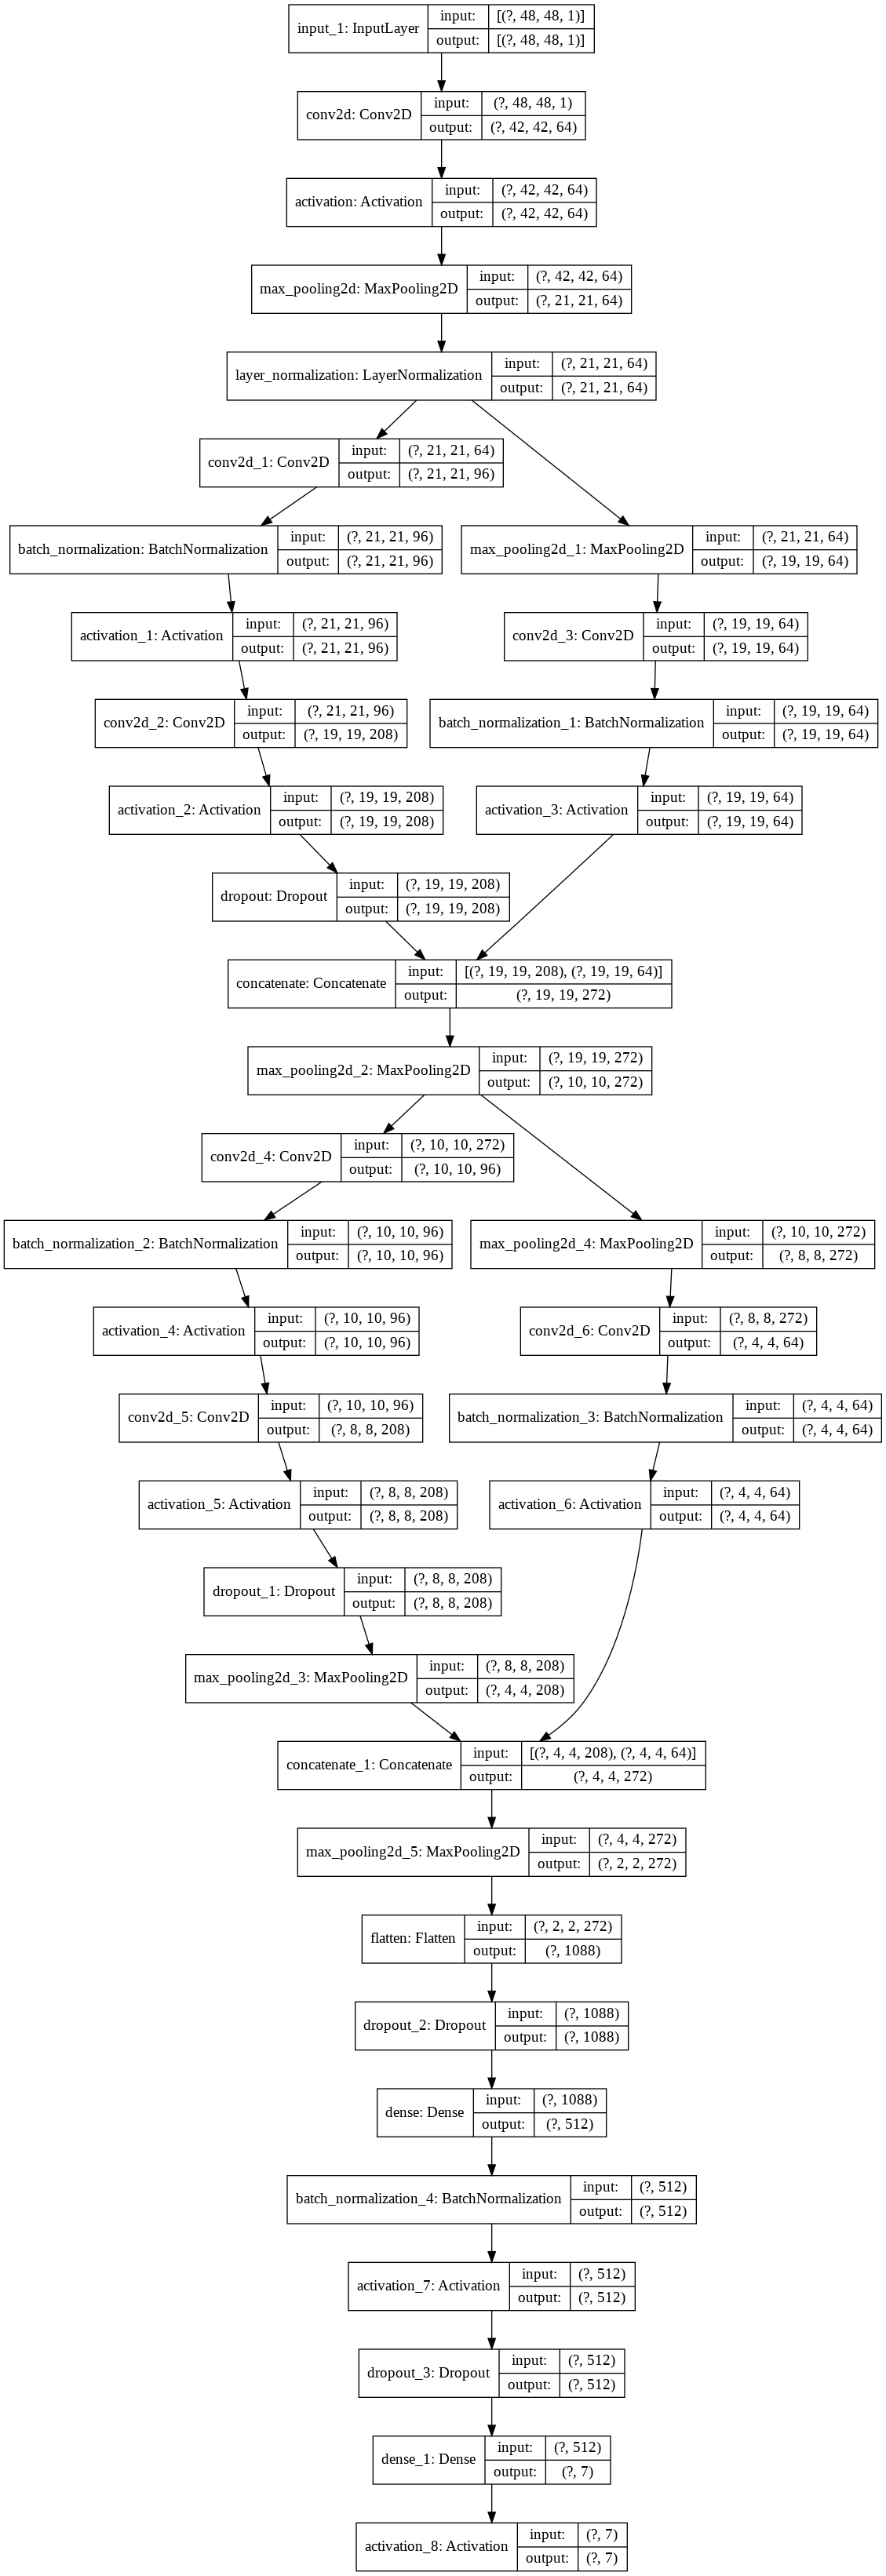

In [0]:
tf.keras.utils.plot_model(model_dex, to_file='model_dex.png', show_shapes=True, show_layer_names=True)

In [0]:
model_dex.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
lr_reducer_d = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=5, verbose=1)

tensorboard_d = tf.keras.callbacks.TensorBoard(log_dir='./logs')

early_stopper_d = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=15, verbose=1, mode='auto')

checkpointer_d = tf.keras.callbacks.ModelCheckpoint('model_dex.h5', monitor='val_loss', verbose=1, save_best_only=True)

In [0]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    zoom_range=0.2,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False,
)

In [0]:
history_dex = model_dex.fit(
    datagen.flow(train_data, y_train, batch_size=256),
    steps_per_epoch=int(np.ceil(X_train.shape[0] / float(128))),
    epochs = 200,
    shuffle=True, 
    validation_data=(val_data, y_validate),
    callbacks=[lr_reducer_d, tensorboard_d, early_stopper_d, checkpointer_d]
)

Epoch 1/200
225/225 [==============================] - ETA: 0s - loss: 1.7763 - accuracy: 0.3295
Epoch 00001: val_loss improved from inf to 1.77579, saving model to model_dex.h5
225/225 [==============================] - 51s 227ms/step - loss: 1.7763 - accuracy: 0.3295 - val_loss: 1.7758 - val_accuracy: 0.2728 - lr: 0.0010
Epoch 2/200
225/225 [==============================] - ETA: 0s - loss: 1.4566 - accuracy: 0.4511
Epoch 00002: val_loss improved from 1.77579 to 1.67380, saving model to model_dex.h5
225/225 [==============================] - 50s 222ms/step - loss: 1.4566 - accuracy: 0.4511 - val_loss: 1.6738 - val_accuracy: 0.3385 - lr: 0.0010
Epoch 3/200
225/225 [==============================] - ETA: 0s - loss: 1.3317 - accuracy: 0.4977
Epoch 00003: val_loss did not improve from 1.67380
225/225 [==============================] - 50s 221ms/step - loss: 1.3317 - accuracy: 0.4977 - val_loss: 1.6836 - val_accuracy: 0.3188 - lr: 0.0010
Epoch 4/200
225/225 [==============================

Text(0.5, 1.0, 'Accuracy Curves')

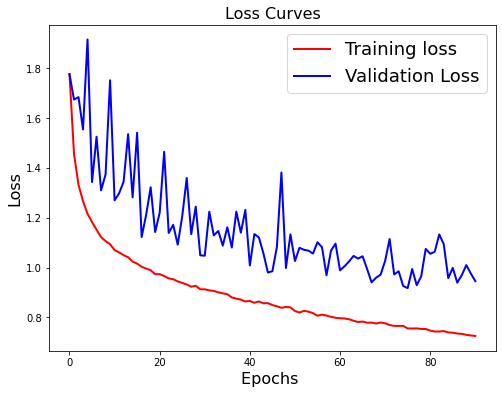

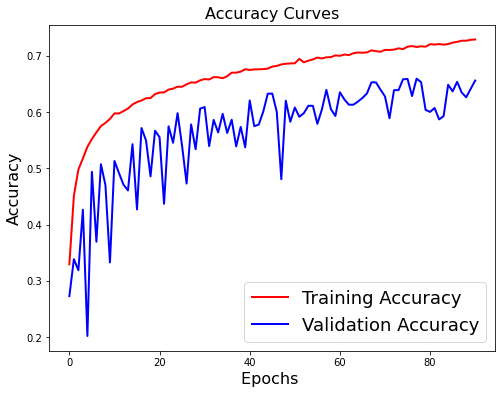

In [18]:
# Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history_dex.history['loss'],'r',linewidth=2.0)
plt.plot(history_dex.history['val_loss'],'b',linewidth=2.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
 
# Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history_dex.history['accuracy'],'r',linewidth=2.0)
plt.plot(history_dex.history['val_accuracy'],'b',linewidth=2.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

In [0]:
def detect_face(image):
  cascPath = '/content/drive/My Drive/BE Project/sarvesh/haarcascades/haarcascade_frontalface_default.xml'
  faceCascade = cv2.CascadeClassifier(cascPath)
  #BGR to gray conversion
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  #Cascade multiscale classifier
  detected_faces = faceCascade.detectMultiScale(image, minNeighbors=6,
                                                minSize=(10,10)
  )
  sub = gray

  for x, y, w, h in detected_faces:
    #if w>100:
      sub = gray[y:y+h,x:x+w]
  return sub,detected_faces

In [0]:
from google.colab.patches import cv2_imshow

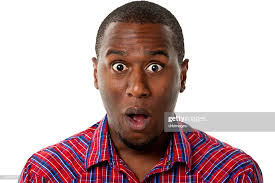

(183, 275, 3)
(99, 99)


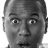

(48, 48)
(1, 48, 48, 1)


In [65]:
image = cv2.imread('/content/drive/My Drive/Datasets/sample_images/person_su3.jpg',1)
cv2_imshow(image)
print(image.shape)
sub_img,detected_face = detect_face(image)
print(sub_img.shape)
sub_img = cv2.resize(sub_img, (48,48), interpolation = cv2.INTER_AREA)
cv2_imshow(sub_img)
print(sub_img.shape)
sub_img = np.reshape(sub_img, (1,48,48,1))
print(sub_img.shape)

In [66]:
pred_array = model_dex.predict(sub_img)
prediction = np.argmax(pred_array)
print(pred_array)
print(prediction)
print(get_label(prediction))

[[3.5845130e-03 2.1427560e-04 1.3664325e-01 2.0714678e-04 2.5325245e-04
  8.5907757e-01 1.9950874e-05]]
5
Surprise


In [67]:
score = model_dex.evaluate(test_data,y_test,steps=100)

100/100 [==============================] - 2s 17ms/step - loss: 0.9850 - accuracy: 0.6406
